In [122]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra
from sentence_transformers import SentenceTransformer


data = pd.read_csv("./data/Exam_Performance_Data.csv", sep=";")
# test scores will be summarized into a meta score, it might be interesting also to see which score is the most...
# ...impactful
data["Test_Meta_Score"] = data["math score"] + data["reading score"] + data["writing score"]

# -------------------- First Step --------------------
def compile_text(x):

    text =  f"""Gender: {x['gender']},  
                Race/Ethnicity: {x['race/ethnicity']}, 
                Parental Level of Education: {x['parental level of education']}, 
                Lunch: {x['lunch']}, 
                Test Preparation Course: {x['test preparation course']}, 
                Math Score: {x['math score']}, 
                Reading Score: {x['reading score']}, 
                Writing Score: {x['writing score']},
                Test Meta Score: {x['Test_Meta_Score']}
            """
            

    return text

sentences = df.apply(lambda x: compile_text(x), axis=1).tolist()

# -------------------- Second Step --------------------

model = SentenceTransformer(r"sentence-transformers/paraphrase-MiniLM-L6-v2")
output = model.encode(sentences=sentences,
         show_progress_bar=True,
         normalize_embeddings=True)

df_embedding = pd.DataFrame(output)
df_embedding

Batches: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.081685,0.002858,0.038341,0.004826,-0.094777,-0.017417,-0.040101,-0.037491,0.005602,0.030797,...,0.003370,0.019493,0.037458,-0.008786,-0.021432,-0.009386,0.208162,-0.010999,-0.002483,0.044217
1,0.090031,0.001364,0.054978,0.001923,-0.077128,-0.033180,-0.021816,-0.039980,0.006838,0.029334,...,0.017202,0.055664,0.057834,-0.009741,-0.048311,0.003629,0.194260,-0.016146,0.008176,0.044488
2,0.095900,-0.001492,0.035616,0.014884,-0.067674,0.000775,-0.018069,-0.054078,0.003804,0.028079,...,0.013139,0.022110,0.042394,0.001950,-0.030820,0.007417,0.187834,-0.020554,0.022829,0.042263
3,0.082811,-0.000937,0.034385,0.000403,-0.094564,-0.019044,-0.030522,-0.036945,-0.000219,0.024400,...,0.013064,0.026426,0.047521,-0.013152,-0.025183,-0.014810,0.213367,-0.002367,-0.002409,0.030449
4,0.095077,-0.035434,0.046267,0.022272,-0.072909,-0.003793,-0.019608,-0.043900,0.026210,0.019438,...,0.012920,0.001440,0.053463,-0.017779,-0.039135,-0.005919,0.182489,-0.016106,0.011759,0.043172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.075301,-0.004488,0.029271,-0.006044,-0.089936,-0.008949,-0.036255,-0.032476,-0.001138,0.029124,...,0.018718,0.017030,0.051226,-0.013577,-0.031351,-0.012716,0.202162,-0.006766,0.011446,0.043536
995,0.095686,-0.018107,0.060404,0.008471,-0.078193,-0.026945,-0.016626,-0.046318,0.026912,0.026216,...,0.020427,0.028023,0.069473,-0.001139,-0.066987,-0.031032,0.184141,-0.012728,0.005192,0.040259
996,0.095999,-0.001598,0.030740,0.008932,-0.075636,-0.013662,-0.036488,-0.035852,-0.005440,0.030371,...,0.011155,0.039017,0.055669,-0.019729,-0.041020,0.018937,0.182652,-0.016208,0.017990,0.040168
997,0.083447,-0.022859,0.039506,0.032511,-0.073239,-0.008545,-0.036753,-0.036587,0.014644,0.035978,...,0.003717,0.028177,0.063332,-0.020458,-0.041349,0.010433,0.193907,-0.013112,0.034475,0.016716


In [123]:
from pyod.models.ecod import ECOD
clf = ECOD()
outliers = clf.fit_predict(df_embedding)

/Users/saarthakkataria/Documents/Code/intro-data-analytics/data_analytics_ws23/data_analytics_ws23-1/.data_analytics/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [124]:
df_embedding['outliers'] = outliers
embedded_data_no_outliers = df_embedding[df_embedding['outliers']==0].drop(columns=['outliers'])
embedded_data_no_outliers.shape

(899, 384)

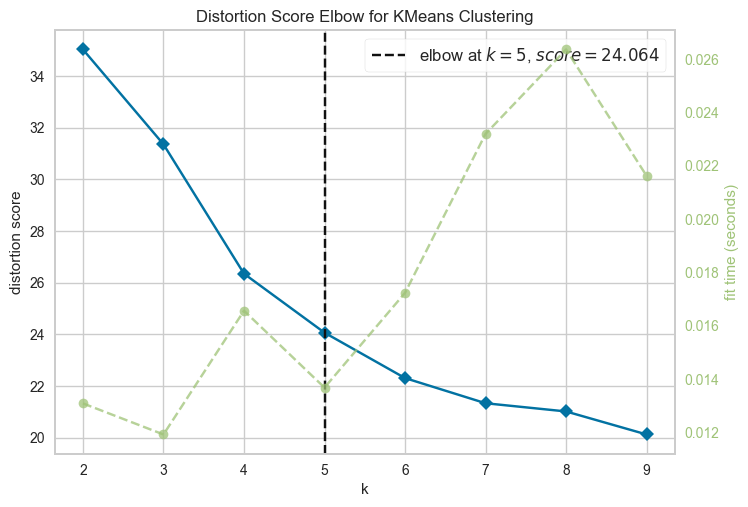

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [125]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(df_embedding_no_outliers)
visualizer.show()

In [143]:
km = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init = 10, max_iter=10000)
clusters = km.fit_predict(df_embedding_no_outliers)

In [144]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure 
of each cluster with its most similar cluster, where similarity 
is the ratio of within-cluster distances to between-cluster distances.

The minimum value of the DB Index is 0, whereas a smaller 
value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(df_embedding_no_outliers,clusters)}")


"""
The silhouette score is a metric used to calculate the goodness of 
fit of a clustering algorithm, but can also be used as 
a method for determining an optimal value of k (see here for more).

Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either
the data or the value of k is incorrect.

1 is the ideal value and indicates that clusters are very 
dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(df_embedding_no_outliers,clusters)}")



Davies bouldin score: 1.8053672959248437
Silhouette Score: 0.21202602982521057


In [145]:
len(clusters)

900

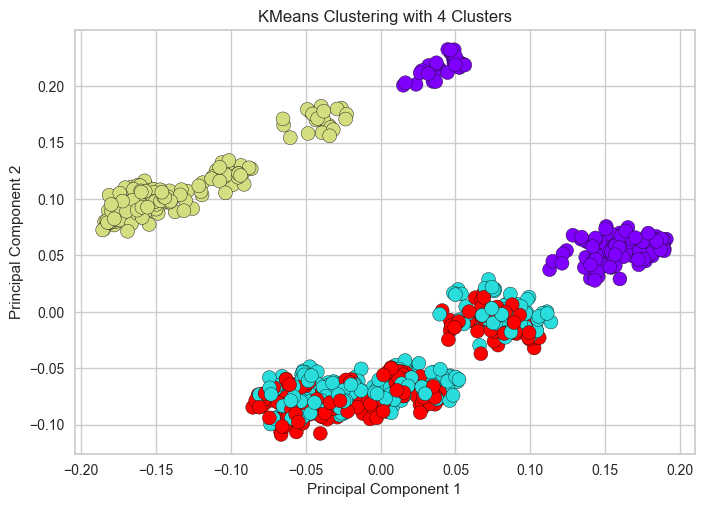

In [146]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce data to 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_embedding_no_outliers)

# Plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='rainbow', edgecolor='k', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with 4 Clusters')
plt.show()

Text(0.5, 0, 'Principal Component 3')

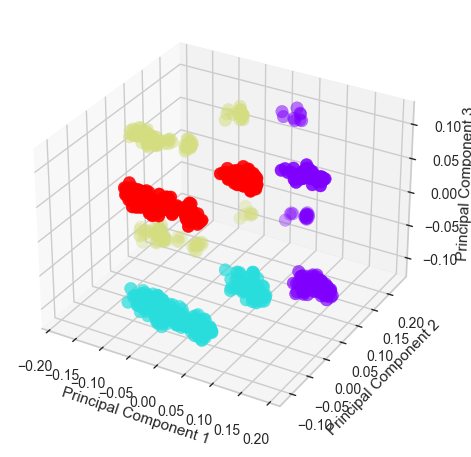

In [147]:
# Reduce data to 3D
pca = PCA(n_components=3)
data_pca = pca.fit_transform(df_embedding_no_outliers)

# 3D-Plot
graph = plt.figure()
axis = graph.add_subplot(projection="3d")
xdata = data_pca[:, 0]
ydata = data_pca[:, 1]
zdata = data_pca[:, 2]
axis.scatter3D(xdata, ydata, zdata, c=clusters, cmap = "rainbow", s=80)
axis.set_xlabel("Principal Component 1")
axis.set_ylabel("Principal Component 2")
axis.set_zlabel("Principal Component 3")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


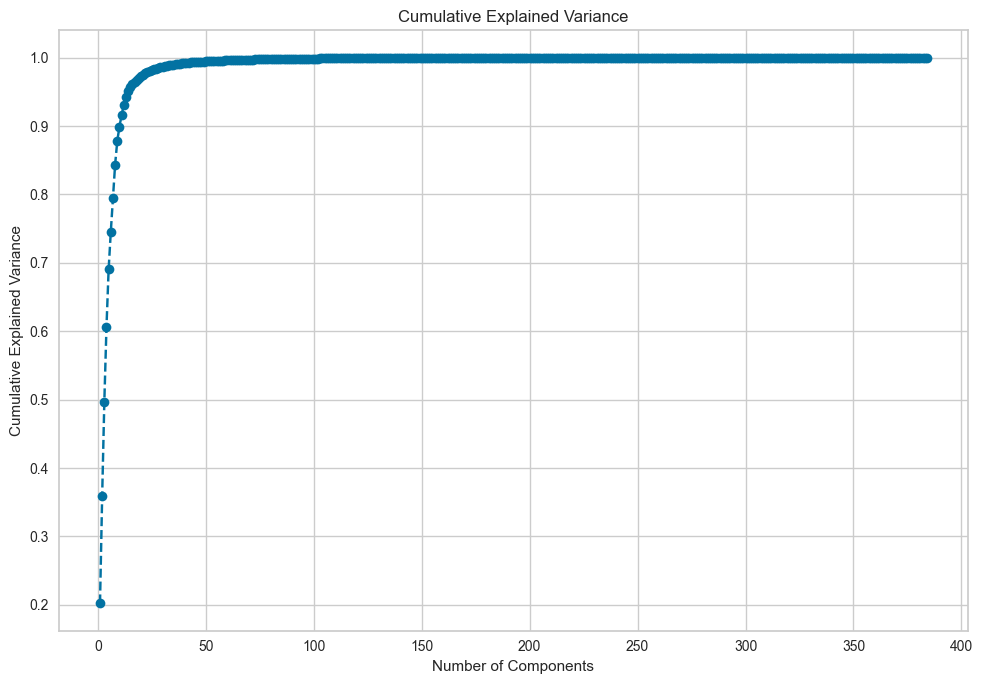

In [148]:
# Assuming your data is in a variable called `data`
pca = PCA().fit(df_embedding_no_outliers)

# Calculate cumulative sum of explained variances
cum_sum = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cum_sum) + 1), cum_sum, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend(loc="best")
plt.tight_layout()
plt.show()